# Engagement Timing & Trend Exploration

This notebook explores when TikTok posts in our dataset perform best and which hashtags/audio trends are surging. Run the ETL & feature pipelines first so that `data/processed/posts.parquet`, `data/features/training_set.parquet`, and `reports/trend_metrics.json` exist.


In [6]:
from pathlib import Path
import json

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 4)


In [ ]:
FEATURE_PATH = Path("data/features/training_set.parquet")
PROCESSED_PATH = Path("data/processed/posts.parquet")
TREND_PATH = Path("reports/trend_metrics.json")

features = pd.read_parquet(FEATURE_PATH)
processed = pd.read_parquet(PROCESSED_PATH)
with TREND_PATH.open() as handle:
    trend_metrics = json.load(handle)

print(f"Features shape: {features.shape}")
print(f"Processed shape: {processed.shape}")
print(f"Trend metrics keys: {list(trend_metrics.keys())[:6]} ...")
features.head()


Features shape: (7225, 33)
Processed shape: (7225, 34)
Trend metrics keys: ['rows', 'features', 'viral_threshold', 'date_range', 'best_hours', 'best_weekdays'] ...


,video_id,author,created_at,created_hour,created_weekday,is_weekend,posting_hour_sin,posting_hour_cos,hours_live,hours_live_bucket,...,likes,comments,shares,plays,engagement_total,engagement_rate,velocity_mean,log_plays,target_metric,is_viral
0,7506183500660313390,dalebrisby90,2025-05-19 15:45:53+00:00,15.0,0.0,0,-0.707107,-0.707107,24.0,12-24h,...,44800,125,1863,686000.0,46788,0.068204,7633.208333,13.438634,28583.333333,0
1,7507316543605280030,jessicafloriolli,2025-05-22 17:02:36+00:00,17.0,3.0,0,-0.965926,-0.258819,24.0,12-24h,...,285700,290,963,1200000.0,286953,0.239127,15489.093750,13.997833,50000.000000,0
2,7507286333505719582,ay_2fya,2025-05-22 15:05:21+00:00,15.0,3.0,0,-0.707107,-0.707107,24.0,12-24h,...,38000,65,496,416100.0,38561,0.092672,4736.052083,12.938683,17337.500000,0
3,7506662216574209310,abell1823,2025-05-20 22:43:34+00:00,22.0,1.0,0,-0.500000,0.866025,24.0,12-24h,...,87200,259,23600,725800.0,111059,0.153016,8717.281250,13.495031,30241.666667,0
4,7506628206280363310,jordanmarielynnxoxo,2025-05-20 20:32:12+00:00,20.0,1.0,0,-0.866025,0.500000,24.0,12-24h,...,77600,724,1196,362100.0,79520,0.219608,4600.208333,12.799678,15087.500000,0


In [15]:
from pathlib import Path
import json

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 4)


## Hour-of-day performance

We average the per-post `target_metric` (plays per hour proxy) across each posting hour to see the strongest windows.


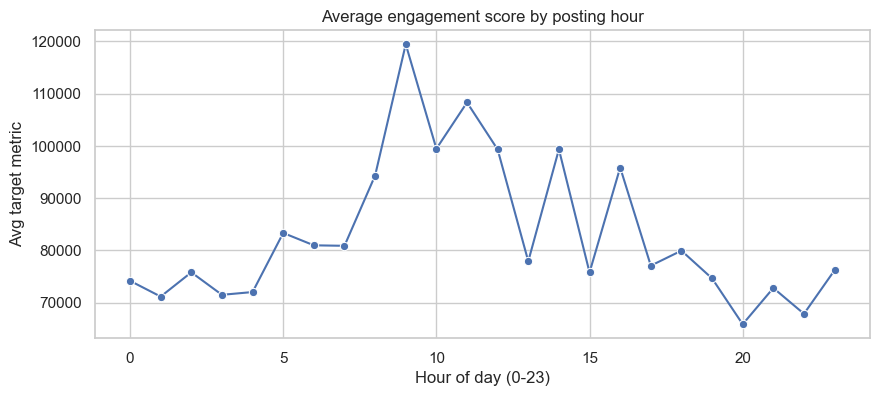

,created_hour,target_metric
9,9.0,119445.634921
11,11.0,108310.458057
10,10.0,99448.891129
14,14.0,99330.643939
12,12.0,99307.291667


In [16]:
hourly_perf = (
    features.groupby("created_hour")["target_metric"].mean().reset_index()
)
fig, ax = plt.subplots()
sns.lineplot(data=hourly_perf, x="created_hour", y="target_metric", marker="o", ax=ax)
ax.set_title("Average engagement score by posting hour")
ax.set_xlabel("Hour of day (0-23)")
ax.set_ylabel("Avg target metric")
plt.show()

hourly_perf.sort_values("target_metric", ascending=False).head()


## Day-of-week signals

Weekday patterns can reveal when audiences are free. Below we look at both mean engagement and viral rate by day.


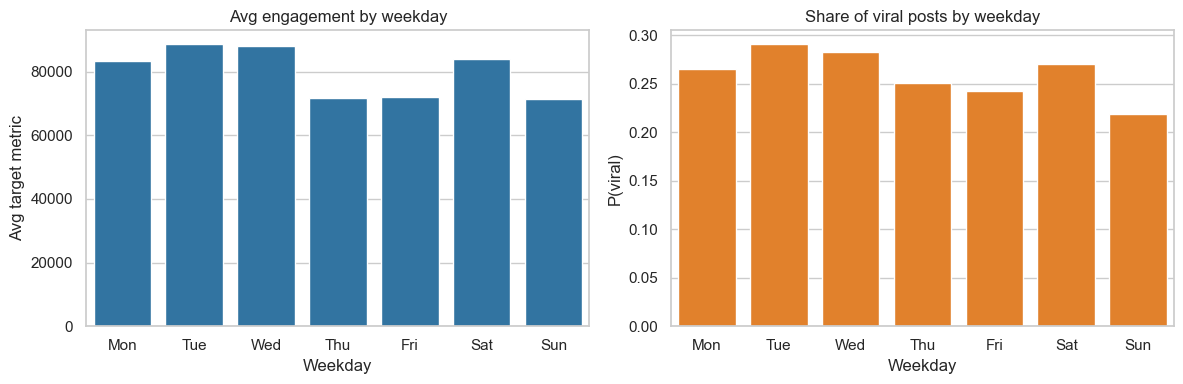

,created_weekday,target_metric,is_viral,weekday_label
1,1.0,88489.537568,0.290353,Tue
2,2.0,87891.878720,0.282143,Wed
5,5.0,83987.540016,0.270108,Sat
0,0.0,83330.160256,0.264835,Mon
3,3.0,71637.613755,0.250390,Thu
4,4.0,72056.953084,0.242613,Fri
6,6.0,71365.962838,0.218919,Sun


In [17]:
weekday_perf = (
    features.groupby("created_weekday")[["target_metric", "is_viral"]]
    .mean()
    .reset_index()
)
weekday_perf["weekday_label"] = weekday_perf["created_weekday"].map(
    {0: "Mon", 1: "Tue", 2: "Wed", 3: "Thu", 4: "Fri", 5: "Sat", 6: "Sun"}
)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.barplot(
    data=weekday_perf, x="weekday_label", y="target_metric", color="#1f77b4", ax=axes[0]
)
axes[0].set_title("Avg engagement by weekday")
axes[0].set_xlabel("Weekday")
axes[0].set_ylabel("Avg target metric")

sns.barplot(
    data=weekday_perf, x="weekday_label", y="is_viral", color="#ff7f0e", ax=axes[1]
)
axes[1].set_title("Share of viral posts by weekday")
axes[1].set_xlabel("Weekday")
axes[1].set_ylabel("P(viral)")
plt.tight_layout()
plt.show()

weekday_perf.sort_values("is_viral", ascending=False)


## Trending topics & audio

We pull the {overall, recent} hashtag & audio lists produced by the feature engineering job.


In [18]:
pd.DataFrame(trend_metrics["top_hashtags_overall"].items(), columns=["hashtag", "count"]).head(10)


,hashtag,count
0,fyp,100
1,юморприколкруги,10
2,fypviral,10
3,foryou,8
4,fypシ,8
5,fypforyou,7
6,streameruniversity,6
7,lanializafypforyoupage,5
8,foryoupagefyp,5
9,tiktokforyou,5


In [19]:
pd.DataFrame(
    trend_metrics["top_hashtags_recent"].items(), columns=["hashtag", "trend_ratio"]
).sort_values("trend_ratio", ascending=False).head(10)


,hashtag,trend_ratio
0,history4thofjulycelebration,3.188854
1,humorcouplecouolegoalsrisasnoviosparejasfunnyt...,3.188854
2,houstonrestaurantsplacestovisit,3.188854
3,houstontxthingstodohoustontexashoustoncheckinp...,3.188854
4,howironic,3.188854
5,humorcomediafypviraltiktok,3.188854
6,humorcomediahumordiversionamigosreels,3.188854
7,humorcomediaviral😂,3.188854
8,hungergamessunriseonthereaping,3.188854
9,horrorhorrortokhorrormovierecommendationmoviec...,3.188854


In [20]:
pd.DataFrame(
    trend_metrics["top_audios_recent"].items(), columns=["audio", "recent_plays"]
).head(10)


,audio,recent_plays
0,original sound,1109
1,sonido original,112
2,оригинальный звук,108
3,ece marketing airball,40
4,som original,19
5,son original,13
6,new flame (but i promise you) (feat. usher & r...,11
7,i aint got no panties on on the dance flooo,8
8,bunna summa,7
9,shake it to the max (fly) (remix),7


## Notes
- Re-run `src.features.build_features` for the latest trend snapshot.
- The tables above can be exported or wired into the dashboard for daily reporting.


# Exploratory Analysis: Best Time to Post

This notebook inspects engagement patterns (hour/day) and trending hashtags/audio for the cleaned TikTok dataset.


In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

sns.set_theme(style="whitegrid")

project_root = Path.cwd()
if project_root.name == "notebooks":
    project_root = project_root.parent

data_path = project_root / "data/features/training_set.parquet"
if not data_path.exists():
    raise FileNotFoundError(
        f"{data_path} not found. Run src/features/build_features.py before this notebook."
    )

df = pd.read_parquet(data_path)
df.head()


,video_id,author,created_at,created_hour,created_weekday,is_weekend,posting_hour_sin,posting_hour_cos,hours_live,hours_live_bucket,...,likes,comments,shares,plays,engagement_total,engagement_rate,velocity_mean,log_plays,target_metric,is_viral
0,7506183500660313390,dalebrisby90,2025-05-19 15:45:53+00:00,15.0,0.0,0,-0.707107,-0.707107,24.0,12-24h,...,44800,125,1863,686000.0,46788,0.068204,7633.208333,13.438634,28583.333333,0
1,7507316543605280030,jessicafloriolli,2025-05-22 17:02:36+00:00,17.0,3.0,0,-0.965926,-0.258819,24.0,12-24h,...,285700,290,963,1200000.0,286953,0.239127,15489.093750,13.997833,50000.000000,0
2,7507286333505719582,ay_2fya,2025-05-22 15:05:21+00:00,15.0,3.0,0,-0.707107,-0.707107,24.0,12-24h,...,38000,65,496,416100.0,38561,0.092672,4736.052083,12.938683,17337.500000,0
3,7506662216574209310,abell1823,2025-05-20 22:43:34+00:00,22.0,1.0,0,-0.500000,0.866025,24.0,12-24h,...,87200,259,23600,725800.0,111059,0.153016,8717.281250,13.495031,30241.666667,0
4,7506628206280363310,jordanmarielynnxoxo,2025-05-20 20:32:12+00:00,20.0,1.0,0,-0.866025,0.500000,24.0,12-24h,...,77600,724,1196,362100.0,79520,0.219608,4600.208333,12.799678,15087.500000,0


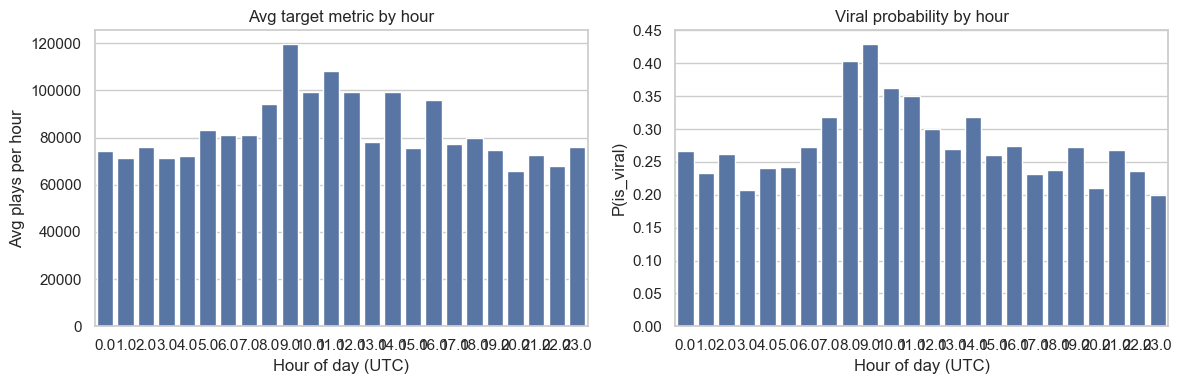

In [ ]:
hourly = (df.groupby("created_hour")
            .agg(mean_target=("target_metric", "mean"),
                 viral_rate=("is_viral", "mean"))
            .reset_index())

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)
sns.barplot(x="created_hour", y="mean_target", data=hourly, ax=axes[0])
axes[0].set_title("Avg target metric by hour")
axes[0].set_xlabel("Hour of day (UTC)")
axes[0].set_ylabel("Avg plays per hour (log scale)")
axes[0].set_yscale("log")

sns.barplot(x="created_hour", y="viral_rate", data=hourly, ax=axes[1])
axes[1].set_title("Viral probability by hour")
axes[1].set_xlabel("Hour of day (UTC)")
axes[1].set_ylabel("P(is_viral)")
plt.tight_layout()
plt.show()


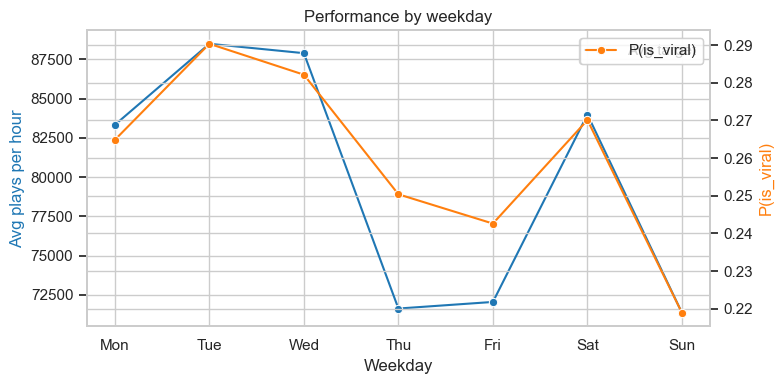

In [31]:
weekday = (df.groupby("weekday_label")
           .agg(mean_target=("target_metric", "mean"),
                viral_rate=("is_viral", "mean"))
           .reindex(["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]))

fig, ax1 = plt.subplots(figsize=(8, 4))
ax2 = ax1.twinx()

sns.lineplot(x=weekday.index, y="mean_target", data=weekday,
             marker="o", label="Avg target", ax=ax1, color="#1f77b4")
sns.lineplot(x=weekday.index, y="viral_rate", data=weekday,
             marker="o", label="P(is_viral)", ax=ax2, color="#ff7f0e")

ax1.set_xlabel("Weekday")
ax1.set_ylabel("Avg plays per hour", color="#1f77b4")
ax2.set_ylabel("P(is_viral)", color="#ff7f0e")
ax1.set_title("Performance by weekday")
fig.tight_layout()
plt.show()


/Users/jessegraham/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12471 (\N{KATAKANA LETTER SI}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


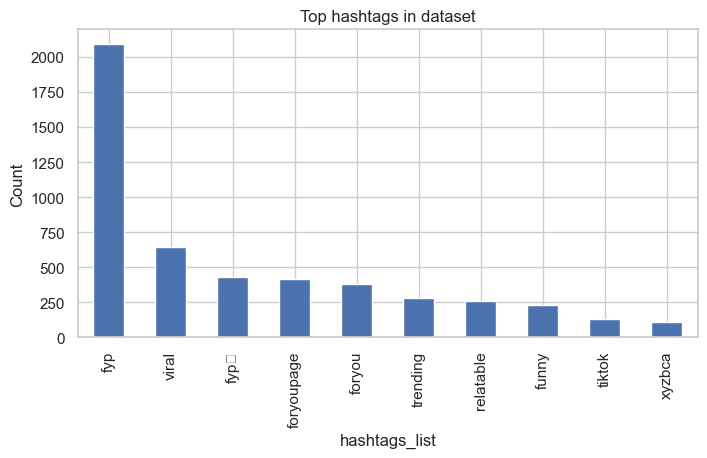

/Users/jessegraham/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12471 (\N{KATAKANA LETTER SI}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


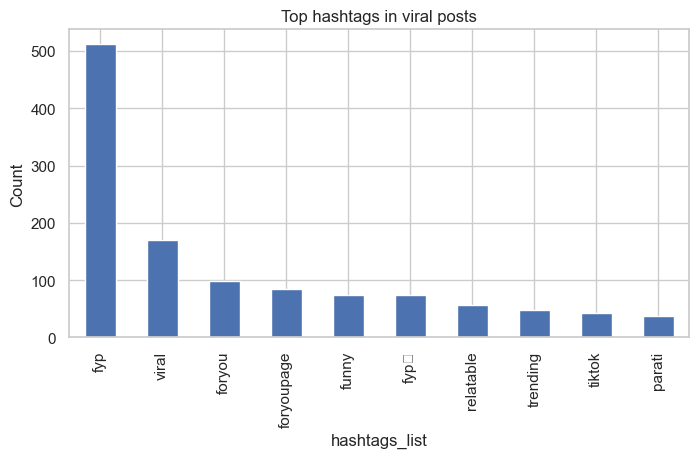

In [35]:
def explode_hashtags(df: pd.DataFrame) -> pd.DataFrame:
    if "hashtags_list" in df:
        return df.copy()
    if "hashtags" in df:
        df = df.copy()
        df["hashtags_list"] = df["hashtags"].fillna("")
    else:
        df["hashtags_list"] = [[] for _ in range(len(df))]
    return df

hashtags_df = explode_hashtags(processed)
hashtags_df = hashtags_df.merge(
    features.loc[:, ["video_id", "is_viral"]], on="video_id", how="left"
)
hashtag_counts = hashtags_df.explode("hashtags_list")
hashtag_counts = hashtag_counts["hashtags_list"].str.lower().str.strip()
top_hashtags = hashtag_counts.value_counts().head(10)

if not top_hashtags.empty:
    top_hashtags.plot(kind="bar", figsize=(8,4), title="Top hashtags in dataset")
    plt.ylabel("Count")
    plt.show()
else:
    print("No hashtags found in dataset.")

top_viral = (hashtags_df[hashtags_df["is_viral"] == 1]
             .explode("hashtags_list")["hashtags_list"].value_counts().head(10))

if not top_viral.empty:
    top_viral.plot(kind="bar", figsize=(8,4), title="Top hashtags in viral posts")
    plt.ylabel("Count")
    plt.show()
else:
    print("No hashtags found among viral posts.")


/var/folders/cf/qmmc728x17xfs8ytzlytjs780000gn/T/ipykernel_38036/964340268.py:12: UserWarning: Glyph 3648 (\N{THAI CHARACTER SARA E}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/cf/qmmc728x17xfs8ytzlytjs780000gn/T/ipykernel_38036/964340268.py:12: UserWarning: Glyph 3626 (\N{THAI CHARACTER SO SUA}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/cf/qmmc728x17xfs8ytzlytjs780000gn/T/ipykernel_38036/964340268.py:12: UserWarning: Glyph 3637 (\N{THAI CHARACTER SARA II}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/cf/qmmc728x17xfs8ytzlytjs780000gn/T/ipykernel_38036/964340268.py:12: UserWarning: Glyph 3618 (\N{THAI CHARACTER YO YAK}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/cf/qmmc728x17xfs8ytzlytjs780000gn/T/ipykernel_38036/964340268.py:12: UserWarning: Glyph 3591 (\N{THAI CHARACTER NGO NGU}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/cf/qmmc728x17xfs8ytzlytjs780000gn/T/ipykernel_38036/964340268.py:12: U

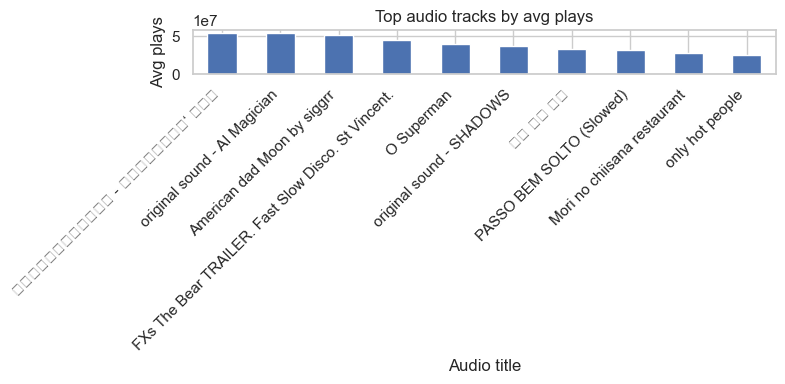

In [38]:
audio_stats = (processed.groupby("music", dropna=False)
                .agg(plays_avg=("plays", "mean"), count=("music", "size"))
                .sort_values(by="plays_avg", ascending=False)
                .head(10))

if not audio_stats.empty:
    audio_stats.plot(kind="bar", y="plays_avg", figsize=(8,4), legend=False)
    plt.title("Top audio tracks by avg plays")
    plt.ylabel("Avg plays")
    plt.xlabel("Audio title")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
else:
    print("No audio metadata available in processed dataset.")
